In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader#, WeightedRandomSampler, Dataset
from torch.utils.data import RandomSampler 
from torch.nn import Sequential, Linear, Conv1d, MaxPool1d, LSTM, Dropout
import torch.optim as optim
import torch.nn as nn

from utils import create_sequences
from utils import create_returns
from utils import MyDataset
from utils import LSTM
from utils import GRU
from utils import train
from utils import plot_loss
from utils import calc_test_loss
from utils import test_confusion_matrix
from utils import test_confusion_matrix_baseline
from utils import autoregression
from utils import convert_returns_to_prices
from utils import plot_conf_matrix
from utils import preds_versus_randwlk
from utils import plot_preds_versus_randwlk

Unknown reason why these below functions cannot be imported from utils - defined in notebook instead

In [2]:
# from utils import create_example_returns_prediction
# from utils import plot_returns
# from utils import create_price_predictions
# from utils import plot_prices
# from utils import random_walk

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cpu


In [85]:
#import and select data
df=pd.read_csv('FTSE100LSTMData.csv')
X = df[['Open']].values
y = df['Close*'].values

**LSTM Model**

In [86]:
#set params for LSTM model
lstm_params = {
    'sequence_length':25,
    'batch_size':8,
    'lr':0.001,
    'epochs':15,
    'num_layers':2,
    'hidden_layer_size':128}

In [87]:
#create sequences of returns
number_sequences = 25
X,y = create_returns(X,y)
X,y = create_sequences(X,y, lstm_params['sequence_length'])
y=y.reshape(-1,1)

In [88]:
#train test valid dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.2, random_state=42, shuffle=False)

In [89]:
#create pytorch datasets
y_train = np.atleast_2d(y_train)  
y_valid = np.atleast_2d(y_valid)  
y_test = np.atleast_2d(y_test)    
train_dataset = MyDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
valid_dataset = MyDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).float())
test_dataset = MyDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [90]:
#define train batch size and create dataloader objects
b_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=lstm_params['batch_size'])
valid_loader = DataLoader(dataset=valid_dataset, batch_size=lstm_params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, batch_size=lstm_params['batch_size'])
#confustion_test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [91]:
#LSTM implementation

In [92]:
lstm_net=LSTM(device, num_layers = lstm_params['num_layers'], hidden_layer_size = lstm_params['hidden_layer_size'])
lstm_net = lstm_net.to(device)
lstm_net.train()

LSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [93]:
#set optimiser and loss function
lstm_optimizer=optim.Adam(lstm_net.parameters(), lr=lstm_params['lr'])
loss_function = nn.MSELoss() # using mean squared error

Epoch= 0 Mean Squared Error =  0.00016220559700213423 Valid Mean Squared Error =  1.6380819943151437e-05
Epoch= 1 Mean Squared Error =  4.369539910556711e-05 Valid Mean Squared Error =  2.358285382797476e-05
Epoch= 2 Mean Squared Error =  3.592626158474816e-05 Valid Mean Squared Error =  2.5286619347753003e-05
Epoch= 3 Mean Squared Error =  3.6254371857913794e-05 Valid Mean Squared Error =  2.6665382392820902e-05
Epoch= 4 Mean Squared Error =  3.657355214592171e-05 Valid Mean Squared Error =  2.5947998437914066e-05
Epoch= 5 Mean Squared Error =  3.6775785206462357e-05 Valid Mean Squared Error =  2.3529642930952832e-05
Epoch= 6 Mean Squared Error =  3.695519278674531e-05 Valid Mean Squared Error =  2.179332841478754e-05
Epoch= 7 Mean Squared Error =  3.7028634720192135e-05 Valid Mean Squared Error =  2.1376239601522684e-05
Epoch= 8 Mean Squared Error =  3.688209890965145e-05 Valid Mean Squared Error =  2.2620932213612832e-05
Epoch= 9 Mean Squared Error =  3.6863228330174744e-05 Valid Me

array(2.3536131e-05, dtype=float32)

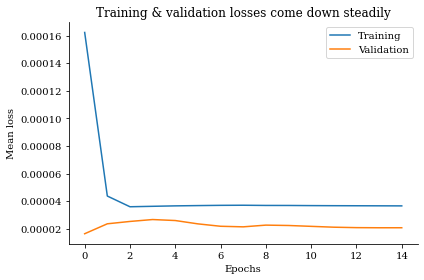

In [94]:
#train, plot loss and calculate mean squared error on testset
lstm_loss_history, lstm_valid_history = train(lstm_net, train_loader, valid_loader, lstm_params['epochs'], device, lstm_optimizer, loss_function)
plot_loss(lstm_loss_history, lstm_valid_history)
calc_test_loss(lstm_net, test_loader, device)

In [95]:
lstm_test_loss = calc_test_loss(lstm_net, test_loader, device)
lstm_test_loss
print(lstm_test_loss)

Mean Squared Error =  2.3536131e-05
2.3536131e-05


In [15]:
# torch.save(lstm_net.state_dict(), "lstm_model_params")

**Load pre-trained LSTM model (with results corresponding to those in the report)**

In [16]:
lstm_loaded = LSTM(device, num_layers = lstm_params['num_layers'], hidden_layer_size = lstm_params['hidden_layer_size'])
lstm_loaded.load_state_dict(torch.load("lstm_model_params"))
lstm_loaded.to(device)
lstm_loaded.eval()
lstm_test_loss = calc_test_loss(lstm_loaded, test_loader, device)

Mean Squared Error =  1.7146369e-05


Overall accuracy =  89.3 %
Predicted up accuracy = 93.2 %
Predicted down accuracy = 85.5 %


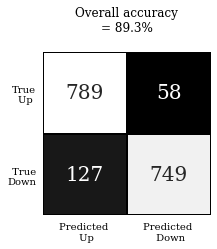

In [17]:
#present confusion matrix of results
cm = test_confusion_matrix(lstm_loaded, test_loader, device)
plot_conf_matrix(cm, y_test)

Infuriatingly the below function also refuses to be imported from utils so it is defined here

In [18]:
def test_confusion_matrix_baseline(test_loader,device):
    all_predictions = torch.tensor([]).to(device)
    labels = torch.tensor([]).to(device)
    retrn_distrb = torch.tensor(df['Close*'].pct_change().dropna().values)

    with torch.no_grad():
        for _,y_batch in test_loader:
            _,y_batch  = _, y_batch.to(device)
            output=torch.tensor(np.random.choice(retrn_distrb, b_size)).to(device).view(b_size,1)
            all_predictions = torch.cat((all_predictions, output), dim=0)
           
            labels = torch.cat((labels, y_batch), dim=0)
        all_predictions = torch.narrow(all_predictions, 0, 0, 1723).view(-1)#need to reduce size by 5 as last batch is cropped
        predictions_iod = torch.tensor([1 if x>0 else 0 for x in all_predictions])
        y_test_iod = torch.tensor([1 if x>0 else 0 for x in labels])

        stacked = torch.stack((predictions_iod,y_test_iod), dim=1)
        confusion_matrix = torch.zeros([2,2])
        for [pred, label] in stacked:
            confusion_matrix[pred][label]+= int(1)
        return confusion_matrix

**Compare to random walk baseline**

Overall accuracy =  51.6 %
Predicted up accuracy = 54.7 %
Predicted down accuracy = 48.4 %


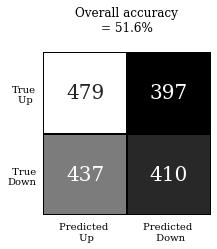

In [19]:
#create confusion matrix based on baseline random walk  - NB as its a random walk it's slightly different each time
cm_baseline  = test_confusion_matrix_baseline(test_loader, device)
plot_conf_matrix(cm_baseline, y_test)

**The following functions for autoregression are defined here and not in utils. They could not be imported from utils for an unknown reason**

In [21]:
def create_example_returns_prediction(model): # specify LSTM or GRU
    #extract some data to compare autogression pred with true values
    auto_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset),shuffle=True) # using the testset data
    X,y_true =next(iter(auto_loader)) # X dims is batch, seq len, num feats  # get first item # or list the iter then idx
    y_preds = autoregression(model, X, n_preds, device) # choosing n_preds worth of predictions
    #concatenate pred and true data with X sequence used as input
    preds_data = np.concatenate([X[0].numpy().squeeze(),y_preds[0]])# take the first example
    true_data = np.concatenate([X[0].numpy().squeeze(),y_true[:n_preds].squeeze()]) # irst X corresponds to first 10 y
    
    return preds_data, true_data

In [22]:
def plot_returns(preds_data, true_data, rolling_av_rebased):
    #plot predicted and true returns
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.plot(preds_data, alpha=0.5, label='Model return preds')
    plt.plot(true_data,alpha =0.5, label='True returns') # depends if y is shuffled
    plt.plot(rolling_av_rebased,label='Rolling av returns')
    plt.title('Predicted and true RETURNS\n')
    plt.legend()
    plt.xlabel('\nTrading days\n \n(Sequence len=25, n_preds=20, returns rebased to 1)')

In [23]:
def create_price_predictions(preds_data, true_data):
    preds_data_reshaped = preds_data.reshape(1, number_sequences+n_preds)# because convert_returns_to_prices assumes a batch input
    true_data_reshaped = true_data.reshape(1, number_sequences+n_preds) 
    pred_prices = convert_returns_to_prices(preds_data_reshaped)
    true_prices = convert_returns_to_prices(true_data_reshaped)
    retrn = random_walk()
    retrn[:number_sequences] = preds_data[:number_sequences]
    random_wlk = retrn.reshape(1, number_sequences+n_preds)
    random_wlk = convert_returns_to_prices(random_wlk)
 
    return pred_prices, true_prices, random_wlk

In [24]:
def plot_prices(pred_prices, true_prices, random_wlk):
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    arr = np.empty(number_sequences-1)
    arr[:] = np.NaN
    random_wlk[0][:number_sequences-1] = arr
    pred_prices[0][:number_sequences-1] = arr
    plt.plot(true_prices[0], label='True prices')
    plt.plot(pred_prices[0], color='green', label='Model preds')
    plt.plot(random_wlk[0], label='Random walk')
    plt.legend()
    plt.title('PRICES: Model predictions compared to true values\n and random walk baseline\n')
    plt.xlabel('\nTrading days\n \n(Sequence len=25, n_preds=20, prices rebased to 1)')

In [25]:
def random_walk():
    retrn_distrb = df['Close*'].pct_change().dropna().to_numpy()
    retrn = np.random.choice(retrn_distrb, n_preds)
    arr = np.empty(number_sequences)
    arr[:] = np.NaN
    retrn = np.insert(retrn,0,arr)
    return retrn

In [26]:
#set the prediction horizon
n_preds=20
# number_sequences = 25 # defined earlier

Create and plot a random sample sequence against model predictions and random walk

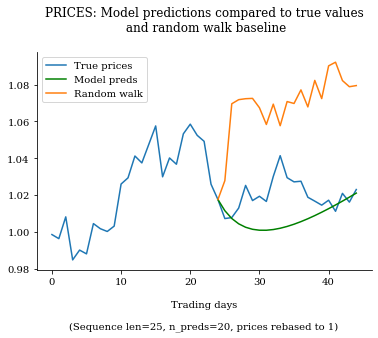

In [27]:
#re-run this cell to get a different sample each time

preds_data, true_data = create_example_returns_prediction(lstm_loaded)
pred_prices, true_prices, random_wlk = create_price_predictions(preds_data, true_data)
plot_prices(pred_prices, true_prices, random_wlk)

**S&P and Nikkei model - 3 input feature sequences**

In [28]:
X_3 =  np.c_[ df[['Open']].values,  df[['S&P Open']].values,  df[['Nikkei Close']].values]
y_3 = df['Close*'].values


lstm_3_params = {
    'sequence_length':25,
    'batch_size':64,
    'lr':0.001,
    'epochs':15,
    'num_layers':2,
    'hidden_layer_size':64,
    'input_dim':3
}


X_3,y_3 = create_returns(X_3,y_3)
X_3,y_3 = create_sequences(X_3,y_3, lstm_3_params['sequence_length'])
#X=X.squeeze()
y_3=y_3.reshape(-1,1)

# print(X_3.shape)
# print(y_3.shape)

#split data with extra features
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,y_3,test_size=0.2, random_state=42)
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X_train_3, y_train_3,test_size=0.2, random_state=42)

In [29]:
y_train_3 = np.atleast_2d(y_train_3)  
y_valid_3 = np.atleast_2d(y_valid_3)  
y_test_3 = np.atleast_2d(y_test_3)    
train_dataset_3 = MyDataset(torch.from_numpy(X_train_3).float(), torch.from_numpy(y_train_3).float())
valid_dataset_3 = MyDataset(torch.from_numpy(X_valid_3).float(), torch.from_numpy(y_valid_3).float())
test_dataset_3 = MyDataset(torch.from_numpy(X_test_3).float(), torch.from_numpy(y_test_3).float())

In [30]:
#define train batch size and create dataloader objects
train_loader_3 = DataLoader(dataset=train_dataset_3,batch_size=lstm_3_params['batch_size'])
valid_loader_3 = DataLoader(dataset=valid_dataset_3, batch_size=lstm_3_params['batch_size'])
test_loader_3 = DataLoader(dataset=test_dataset_3, batch_size=lstm_3_params['batch_size'])

Epoch= 0 Mean Squared Error =  0.00043170926625768106 Valid Mean Squared Error =  6.75961491651833e-05
Epoch= 1 Mean Squared Error =  0.00010763815648140568 Valid Mean Squared Error =  5.714624421671033e-05
Epoch= 2 Mean Squared Error =  9.595689125594565e-05 Valid Mean Squared Error =  4.9194473831448704e-05
Epoch= 3 Mean Squared Error =  8.651834487581851e-05 Valid Mean Squared Error =  4.140800956520252e-05
Epoch= 4 Mean Squared Error =  7.787271243123333e-05 Valid Mean Squared Error =  3.3349337172694504e-05
Epoch= 5 Mean Squared Error =  6.930950799326e-05 Valid Mean Squared Error =  2.4622317141620442e-05
Epoch= 6 Mean Squared Error =  6.0369707934187736e-05 Valid Mean Squared Error =  1.619591421331279e-05
Epoch= 7 Mean Squared Error =  5.2051807368366885e-05 Valid Mean Squared Error =  1.093675473384792e-05
Epoch= 8 Mean Squared Error =  4.763352520883969e-05 Valid Mean Squared Error =  8.89213515620213e-06
Epoch= 9 Mean Squared Error =  4.601128452039162e-05 Valid Mean Squared

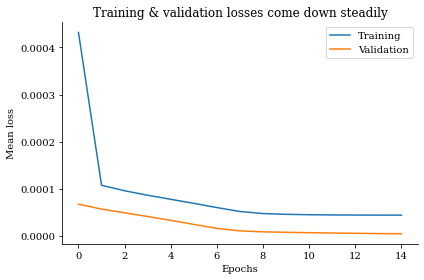

In [31]:
lstm_net_3 = LSTM(device, input_size = lstm_3_params['input_dim'], num_layers = lstm_3_params['num_layers'], hidden_layer_size = lstm_3_params['hidden_layer_size'])
lstm_net_3 = lstm_net_3.to(device)
lstm_optimizer_3=optim.Adam(lstm_net_3.parameters(), lr=lstm_3_params['lr'])#remake optimiser to fit lstm_net_3
lstm_loss_history3, lstm_valid_history3 = train(lstm_net_3, train_loader_3, valid_loader_3, lstm_3_params['epochs'], device,lstm_optimizer_3, loss_function )
plot_loss(lstm_loss_history3, lstm_valid_history3)


In [32]:
# torch.save(lstm_net_3.state_dict(), "lstm_3_model_params")

**Loading pre-trained LSTM3 model corresponding to results presented in report**

In [33]:
lstm_3_loaded = LSTM(device, input_size = lstm_3_params['input_dim'], num_layers = lstm_3_params['num_layers'], hidden_layer_size = lstm_3_params['hidden_layer_size'])
lstm_3_loaded.load_state_dict(torch.load("lstm_3_model_params"))
lstm_3_loaded.to(device)
lstm_3_loaded.eval()
lstm_3_test_loss = calc_test_loss(lstm_3_loaded, test_loader_3, device)

Mean Squared Error =  1.9287243e-05


Overall accuracy =  83.9 %
Predicted up accuracy = 92.9 %
Predicted down accuracy = 77.1 %


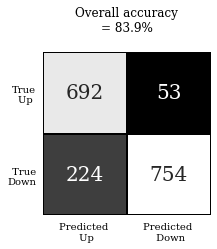

In [34]:
cm_3 = test_confusion_matrix(lstm_3_loaded, test_loader_3, device) # make confusion matrix
plot_conf_matrix(cm_3, y_test_3)

**GRU Model**

In [35]:
gru_params = {
    'sequence_length':25,
    'batch_size':64,
    'lr':0.0003,
    'epochs':13,
    'num_layers':2,
    'hidden_layer_size':64
}

In [36]:
gru=GRU(device, num_layers = gru_params['num_layers'], hidden_dim = gru_params['hidden_layer_size'])
gru.to(device)
gru.train()
gru_optimizer=optim.Adam(gru.parameters(), lr=gru_params['lr'])


Epoch= 0 Mean Squared Error =  0.0015112726109325833 Valid Mean Squared Error =  7.845975051168352e-05
Epoch= 1 Mean Squared Error =  0.00012908293359649325 Valid Mean Squared Error =  7.578253280371428e-05
Epoch= 2 Mean Squared Error =  0.00012593768937138562 Valid Mean Squared Error =  7.318253483390436e-05
Epoch= 3 Mean Squared Error =  0.00012193278076017447 Valid Mean Squared Error =  6.958276208024472e-05
Epoch= 4 Mean Squared Error =  0.00011659214524324748 Valid Mean Squared Error =  6.470594962593168e-05
Epoch= 5 Mean Squared Error =  0.00010965289151625193 Valid Mean Squared Error =  5.832614260725677e-05
Epoch= 6 Mean Squared Error =  0.00010103380312405837 Valid Mean Squared Error =  5.058250098954886e-05
Epoch= 7 Mean Squared Error =  9.091375450852552e-05 Valid Mean Squared Error =  4.1843079088721424e-05
Epoch= 8 Mean Squared Error =  7.984829208835017e-05 Valid Mean Squared Error =  3.249202200095169e-05
Epoch= 9 Mean Squared Error =  6.888416008997024e-05 Valid Mean Sq

array(1.6800397e-05, dtype=float32)

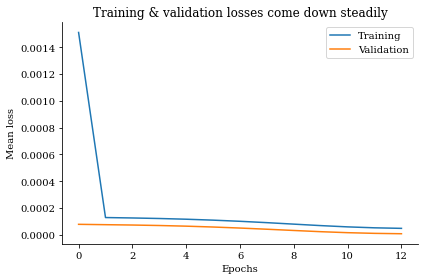

In [37]:
loss_historyGRU, valid_historyGRU = train(gru, train_loader, valid_loader, gru_params['epochs'], device, gru_optimizer, loss_function)
plot_loss(loss_historyGRU, valid_historyGRU)
calc_test_loss(gru, test_loader, device)

In [38]:
# torch.save(gru.state_dict(), "gru_model_params")

In [39]:
gru_loaded = GRU(device, num_layers = gru_params['num_layers'], hidden_dim = gru_params['hidden_layer_size'])
gru_loaded.load_state_dict(torch.load("gru_model_params"))
gru_loaded.to(device)
gru_loaded.eval()
gru_loaded_test_loss = calc_test_loss(gru_loaded, test_loader, device)

Mean Squared Error =  1.7128183e-05


Overall accuracy =  90.3 %
Predicted up accuracy = 92.8 %
Predicted down accuracy = 87.7 %


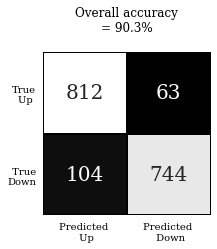

In [40]:
cm_gru = test_confusion_matrix(gru_loaded, test_loader, device)
plot_conf_matrix(cm_gru, y_test)

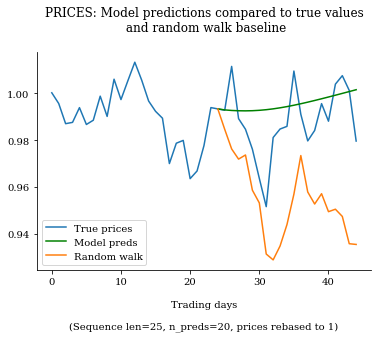

In [68]:
#sample model predictions against true prices and random walk baseline
#re-run cell for a new sample each time

preds_data, true_data = create_example_returns_prediction(gru_loaded)
pred_prices, true_prices, random_wlk = create_price_predictions(preds_data, true_data)
plot_prices(pred_prices, true_prices, random_wlk)

**GRU automated evaluation of MSE compare to true values over a range of n_preds compared to random walk**

For unknown reason preds_versus_randwlk() cannot be imported from utils so is defined here

In [42]:
def preds_versus_randwlk(model, n_low, n_high, n_samples):
    mse_preds=[]
    mse_random_wlks=[]
    for n in range(n_low,n_high):
        n_preds=n
        pred_prices_lst=[]
        true_prices_lst=[]
        random_wlk_lst=[]
        for i in range(n_samples):
            preds_data, true_data = create_example_returns_prediction(model)
            pred_prices, true_prices, random_wlk = create_price_predictions(preds_data, true_data)
            pred_prices_lst.append(pred_prices.reshape(-1)[-1])
            true_prices_lst.append(true_prices.reshape(-1)[-1])
            random_wlk_lst.append(random_wlk.reshape(-1)[-1])
        mse_pred = mean_squared_error(true_prices_lst, pred_prices_lst)
        mse_random_wlk = mean_squared_error(true_prices_lst, random_wlk_lst)
        mse_preds.append(mse_pred)
        mse_random_wlks.append(mse_random_wlk)
    return mse_preds, mse_random_wlks

In [43]:
#load pre_calculated arrays based on n_preds in range 2,100 averaged over 1000 samples for each n_pred
#calculation takes 4 hours on a GPU, however the same trend can be seen with choppier data with lower sample numbers 
#using the preds_versus_randwlk() commented out below


# mse_preds, mse_random_wlks = preds_versus_randwlk(gru_loaded, n_low=2, n_high=100, n_samples=100) #these params take 5 min 
# uncomment and change params/model to test

#load pre-calcuated results (took 4 hours to calculate on GPU)
mse_preds = np.load('mse_preds.npy')
mse_random_wlks = np.load('mse_random_wlks.npy')

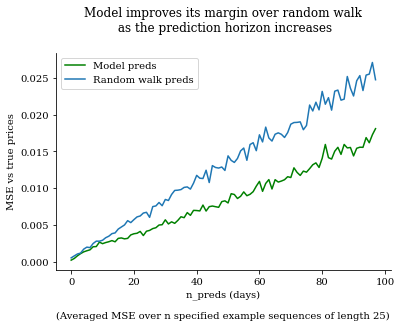

In [44]:
plot_preds_versus_randwlk(mse_preds,mse_random_wlks)

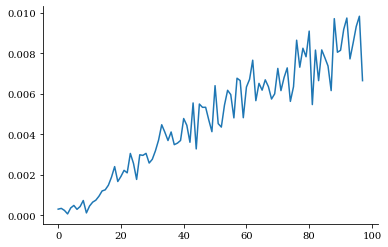

In [45]:
#just to demonstrate the difference is increasing
plt.plot([a - b for a, b in zip(mse_random_wlks, mse_preds)])

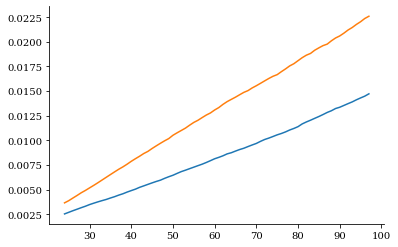

In [46]:
#even clearer with a rolling average  - adjust .rolling(param) to suit a custom example
mse_preds_rolling  = pd.Series(mse_preds).rolling(25).mean()
mse_random_wlks_rolling=pd.Series(mse_random_wlks).rolling(25).mean()
plt.plot(mse_preds_rolling)
plt.plot(mse_random_wlks_rolling)

**GRU Model with S&P and Nikkei - 3 input feature model**

In [47]:
gru_3_params = {
    'sequence_length':25,
    'batch_size':64,
    'lr':0.0003,
    'epochs':15,
    'num_layers':2,
    'hidden_layer_size':128,
    'input_dim':3
}



gru_3=GRU(device, input_dim = gru_3_params['input_dim'], num_layers = gru_3_params['num_layers'], hidden_dim = gru_3_params['hidden_layer_size'])
gru_3.to(device)
gru_3.train()
gru_optimizer_3=optim.Adam(gru_3.parameters(), lr=gru_3_params['lr'])


Epoch= 0 Mean Squared Error =  0.000139232442815301 Valid Mean Squared Error =  7.595127681270242e-05
Epoch= 1 Mean Squared Error =  0.00012799737380881761 Valid Mean Squared Error =  7.163910049712285e-05
Epoch= 2 Mean Squared Error =  0.00011867157729869794 Valid Mean Squared Error =  5.874941416550428e-05
Epoch= 3 Mean Squared Error =  9.923866305509636e-05 Valid Mean Squared Error =  3.4958218748215586e-05
Epoch= 4 Mean Squared Error =  7.291696704345376e-05 Valid Mean Squared Error =  2.087296343233902e-05
Epoch= 5 Mean Squared Error =  5.843879172197763e-05 Valid Mean Squared Error =  1.3566063898906577e-05
Epoch= 6 Mean Squared Error =  5.201483984809334e-05 Valid Mean Squared Error =  1.024793255055556e-05
Epoch= 7 Mean Squared Error =  4.8811686161340844e-05 Valid Mean Squared Error =  9.18334899324691e-06
Epoch= 8 Mean Squared Error =  4.7273474550841446e-05 Valid Mean Squared Error =  8.37970401335042e-06
Epoch= 9 Mean Squared Error =  4.656603109076801e-05 Valid Mean Square

array(2.13742e-05, dtype=float32)

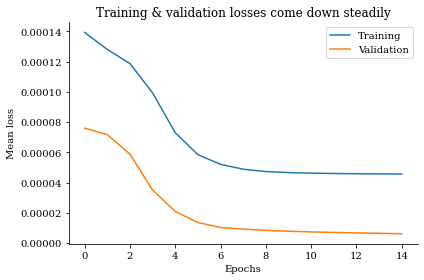

In [48]:
loss_historyGRU_3, valid_historyGRU_3 = train(gru_3, train_loader_3, valid_loader_3, gru_3_params['epochs'], device, gru_optimizer_3, loss_function)
plot_loss(loss_historyGRU_3, valid_historyGRU_3)
calc_test_loss(gru_3, test_loader_3, device)

In [49]:
# torch.save(gru_3.state_dict(), "gru_3_model_params")

In [50]:
# load pre-trained model with results corresponding to the report

gru_3_loaded = GRU(device, input_dim = gru_3_params['input_dim'], num_layers = gru_3_params['num_layers'], hidden_dim = gru_3_params['hidden_layer_size'])
gru_3_loaded.load_state_dict(torch.load("gru_3_model_params"))
gru_3_loaded.to(device)
gru_3_loaded.eval()
gru_3_test_loss = calc_test_loss(gru_3_loaded, test_loader_3, device)

Mean Squared Error =  1.8634972e-05


Overall accuracy =  88.9 %
Predicted up accuracy = 91.6 %
Predicted down accuracy = 86.2 %


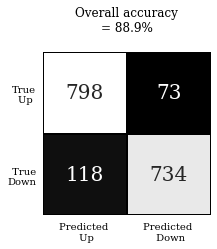

In [51]:
cm_gru_3 = test_confusion_matrix(gru_3_loaded, test_loader_3, device)
plot_conf_matrix(cm_gru_3, y_test_3)

Plot how the training proceeds according to validation loss per epoch for the difference models

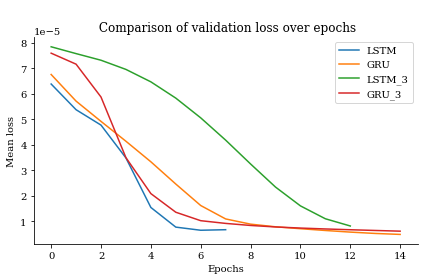

In [52]:
from utils import plot_loss_compare
plot_loss_compare(lstm_valid_history ,lstm_valid_history3 ,valid_historyGRU ,valid_historyGRU_3)